In [37]:
#Libraries

import os 
import tarfile
import urllib3
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
#importing data from URL
url = 'https://raw.githubusercontent.com/ageron/handson-ml/ac1310a3cc1567ecfb4b798715c804627076775f/datasets/housing/housing.csv'

In [3]:
data = pd.read_csv(url)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


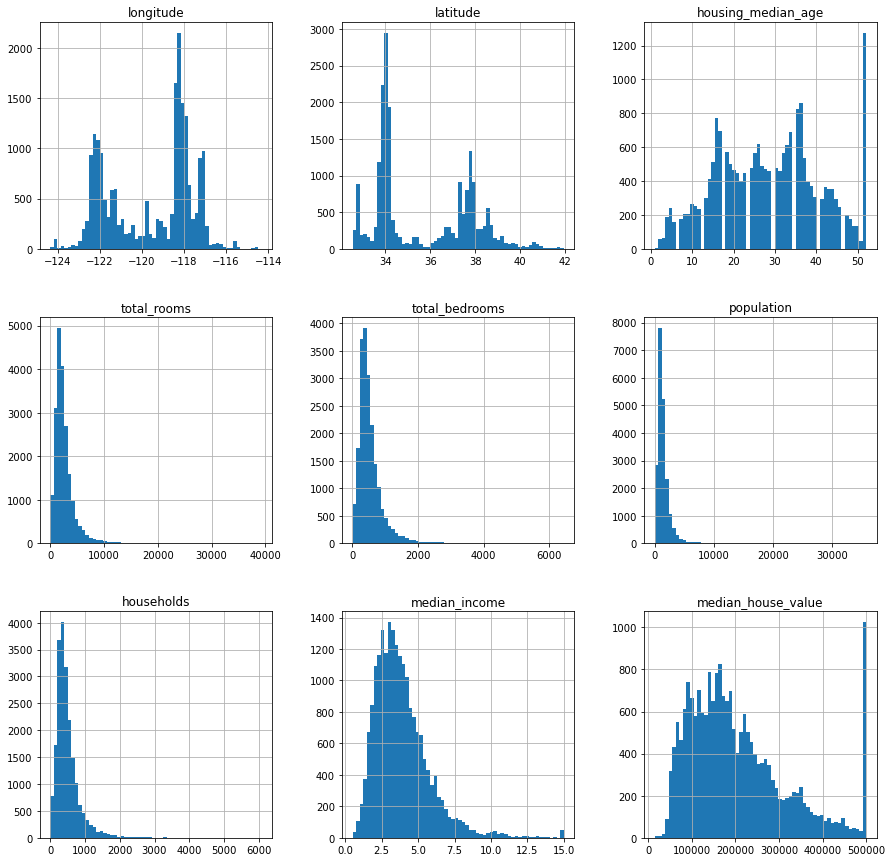

In [7]:
%matplotlib inline
data.hist(bins=60,figsize=(15,15))
plt.show()

In [8]:
#test set function
def split_train_test(data_set, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
#creating test set of 20% of the dataset.
train_set, test_set = split_train_test(data, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [10]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = data.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
housing_with_id["id"] = data["longitude"] * 1000 + data["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
#Create income category attribute
data['income_cat'] = np.ceil(data["median_income"] / 1.5)
data['income_cat'].where(data['income_cat'] < 5, 5.0, inplace= True)

In [14]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2.0


In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [16]:
data["income_cat"].value_counts() / len(data) * 100

3.0    35.058140
2.0    31.884690
4.0    17.630814
5.0    11.443798
1.0     3.982558
Name: income_cat, dtype: float64

In [17]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [18]:
data = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

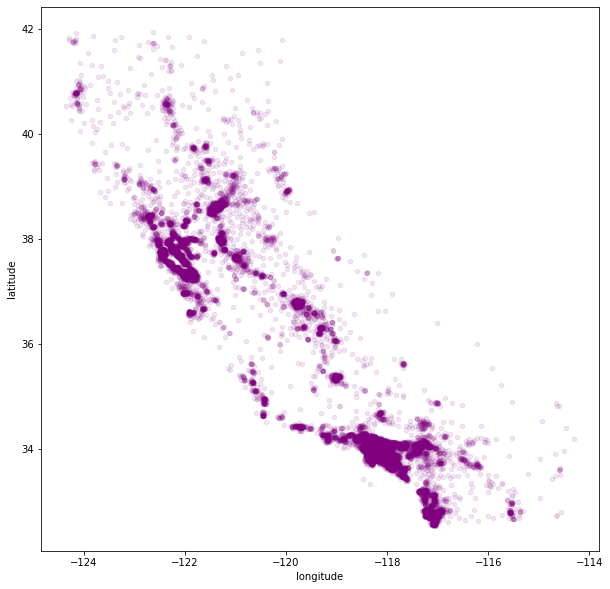

In [19]:
data.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,10), color='purple', alpha=0.1)

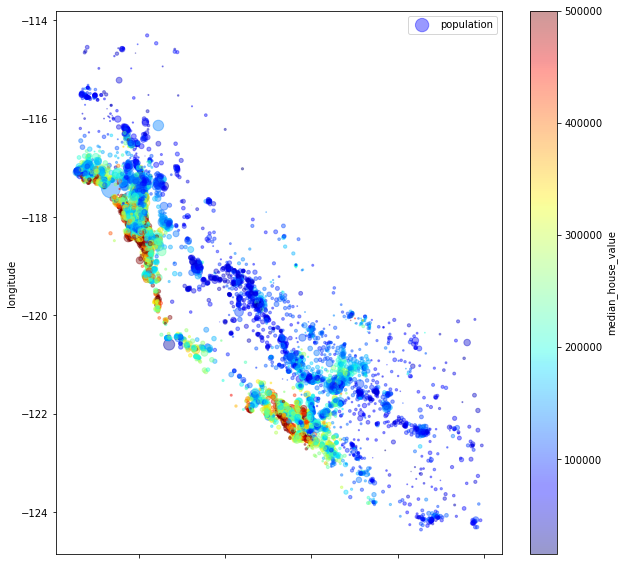

In [20]:
data.plot(kind='scatter', x='latitude', y='longitude', alpha=0.4, s=data["population"]/100, label='population', c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True,
figsize=(10,10))
plt.legend()

In [21]:
#correlatino coefficent

corr_matrix = data.corr()
corr_matrix

/tmp/ipykernel_36913/1919620318.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [22]:
corr_matrix["median_house_value"]

longitude            -0.047466
latitude             -0.142673
housing_median_age    0.114146
total_rooms           0.135140
total_bedrooms        0.047781
population           -0.026882
households            0.064590
median_income         0.687151
median_house_value    1.000000
Name: median_house_value, dtype: float64

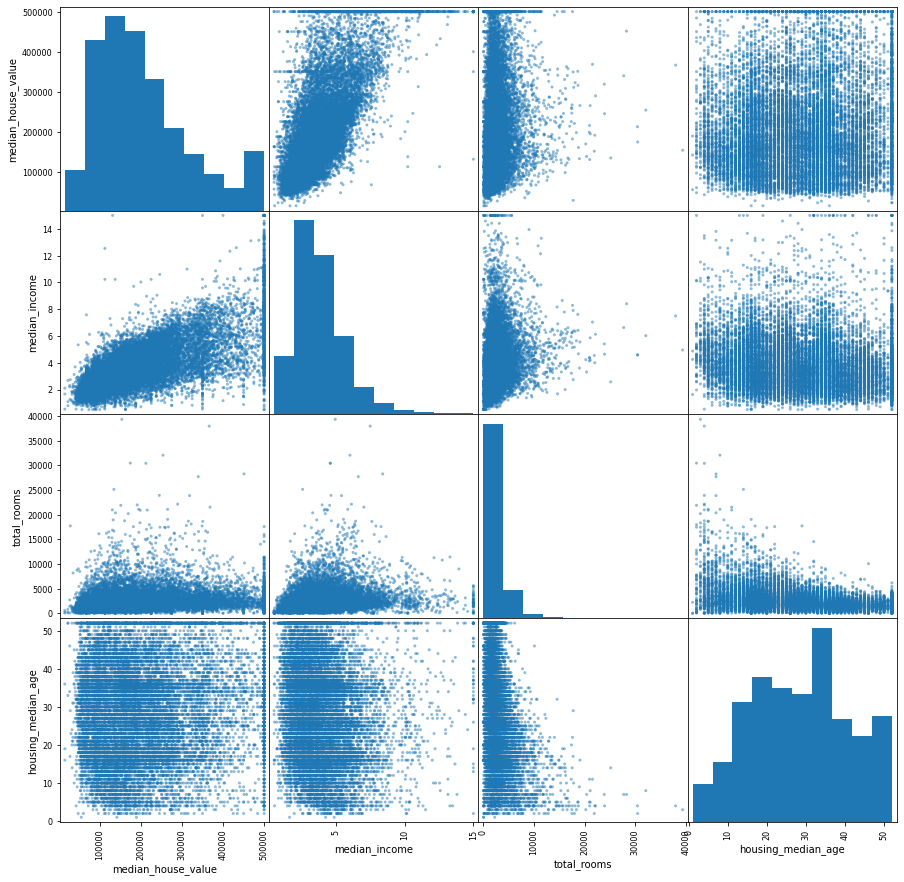

In [23]:
%matplotlib inline

attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
pd.plotting.scatter_matrix(data[attributes], figsize=(15, 15))
plt.show()

In [24]:
data["rooms_per_household"] = data["total_rooms"]/data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"]/data["total_rooms"]
data["population_per_household"]=data["population"]/data["households"]

In [25]:
corr_matrix = data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

/tmp/ipykernel_36913/3333327041.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [26]:
data =strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [27]:

imputer = SimpleImputer(strategy="median")

In [28]:
housing_num = data.drop("ocean_proximity", axis=1)

In [29]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [31]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [32]:
X = imputer.transform(housing_num)

In [33]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [35]:
encoder = LabelEncoder()
houseing_cat = data["ocean_proximity"]
houseing_cat_encoded = encoder.fit_transform(houseing_cat)
houseing_cat_encoded

array([1, 4, 1, ..., 0, 0, 1])

In [36]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [40]:
encoder = OneHotEncoder()
houseing_cat_1hot = encoder.fit_transform(houseing_cat_encoded.reshape(-1,1))
houseing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>